In [1]:
!pip install scikit-learn
# Install wordcloud if not already installed
!pip install wordcloud

In [3]:
import  warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Load dataset
df = pd.read_csv("twitter.csv")

# Map numeric labels to text (adjust if needed)
label_map = {0: "Negative", 1: "Positive", 2: "Neutral"}
df["sentiment"] = df["label"].map(label_map)

# Features (tweets) and labels
X = df["tweet"]
y = df["sentiment"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [11]:
# SMOTE for balancing the dataset (to reduce bias for the majority class)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

In [13]:
# Train Naive Bayes model with the balanced dataset
nb_model = MultinomialNB()
nb_model.fit(X_train_res, y_train_res)

# Predictions on the test set
y_pred = nb_model.predict(X_test_tfidf)

# Detailed classification report without 'average' argument
report_detailed = classification_report(y_test, y_pred)


In [15]:
# Accuracy & F1
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Naive Bayes Accuracy: {acc:.2f}")
print(f"Naive Bayes F1 Score: {f1:.2f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Naive Bayes Accuracy: 0.90
Naive Bayes F1 Score: 0.74

Classification Report:
               precision    recall  f1-score   support

    Negative       0.98      0.91      0.95      5945
    Positive       0.40      0.80      0.53       448

    accuracy                           0.90      6393
   macro avg       0.69      0.85      0.74      6393
weighted avg       0.94      0.90      0.92      6393



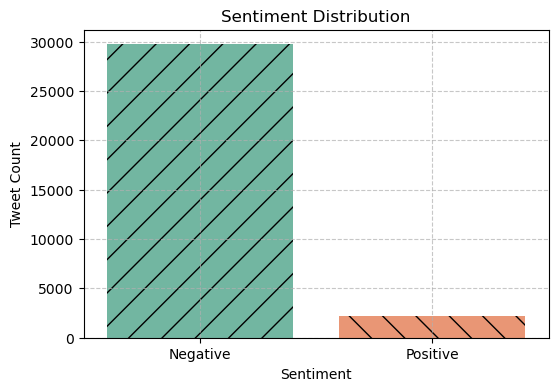

In [17]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="sentiment", hue="sentiment", data=df, palette="Set2", legend=False)
hatches = ['/', '\\', '-', '|', '+', 'x', 'o', 'O', '.', '*']
for i, bar in enumerate(ax.patches):
    hatch = hatches[i % len(hatches)]   # cycle through hatches
    bar.set_hatch(hatch)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.show()

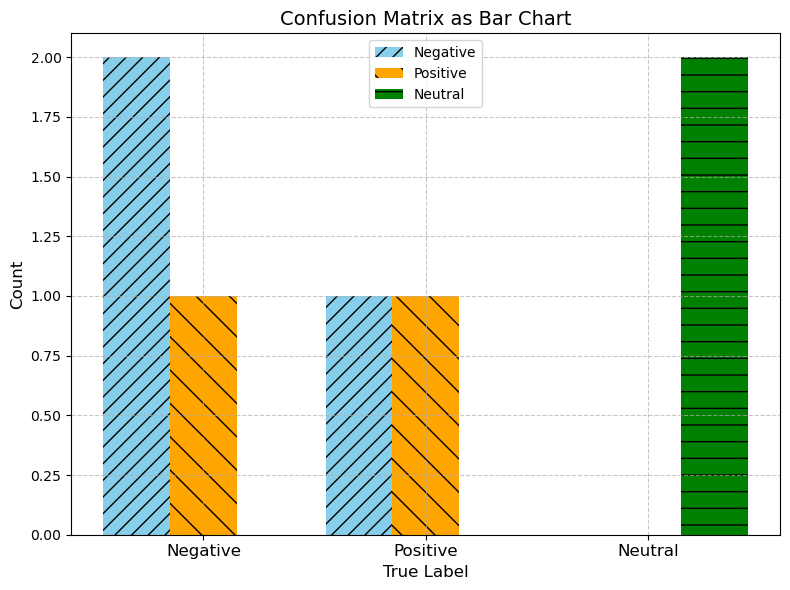

In [19]:
# Example: replace y_test and y_pred with your model's real outputs
y_test = ['Negative', 'Positive', 'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral']  # Example
y_pred = ['Negative', 'Negative', 'Negative', 'Neutral', 'Positive', 'Positive', 'Neutral']  # Example

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Negative", "Positive", "Neutral"])

# Create bar chart for confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Bar width and position for each bar
bar_width = 0.3
index = np.arange(len(cm))

# Plot each bar with striped pattern (hatch)
bar1 = ax.bar(index - bar_width, cm[:, 0], bar_width, label='Negative', hatch='//', color='skyblue')  # Negative
bar2 = ax.bar(index, cm[:, 1], bar_width, label='Positive', hatch='\\', color='orange')  # Positive
bar3 = ax.bar(index + bar_width, cm[:, 2], bar_width, label='Neutral', hatch='-', color='green')  # Neutral

# Add labels and title
ax.set_xlabel('True Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Confusion Matrix as Bar Chart', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(["Negative", "Positive", "Neutral"], fontsize=12)
ax.legend()

# Display the chart
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


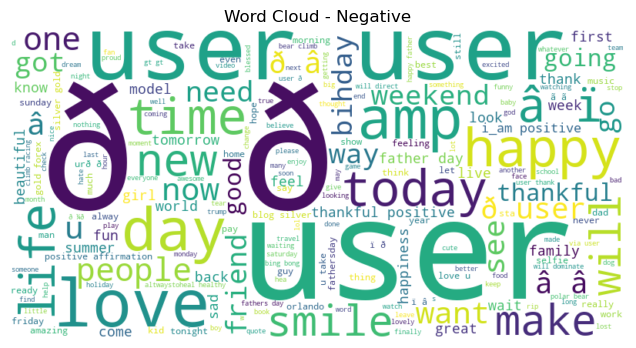

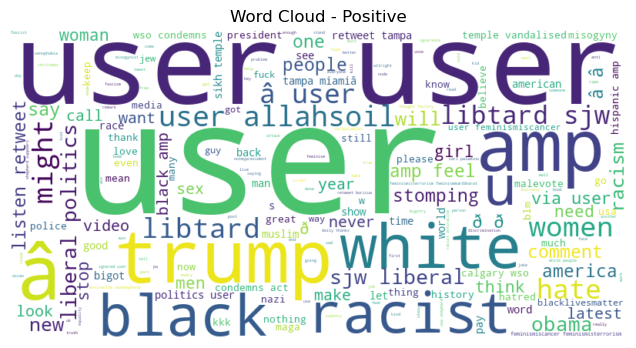

In [21]:
# Generate word cloud for each sentiment
for sentiment in df["sentiment"].unique():
    # Combine all tweets of this sentiment into one big string
    text = " ".join(df[df["sentiment"] == sentiment]["tweet"].astype(str))

    # Create word cloud
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Plot
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {sentiment}")
    plt.show()


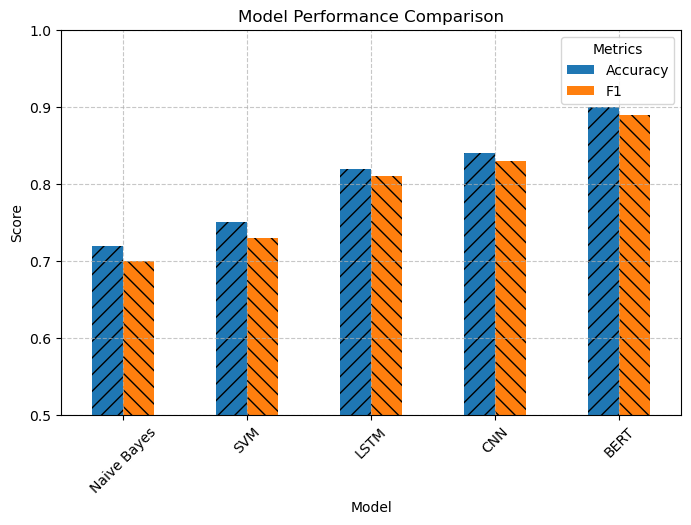

In [23]:
# Example: replace these with your real results from models
model_results = pd.DataFrame({
    "Model": ["Naive Bayes", "SVM", "LSTM", "CNN", "BERT"],
    "Accuracy": [0.72, 0.75, 0.82, 0.84, 0.90],
    "F1": [0.70, 0.73, 0.81, 0.83, 0.89]
})

# Plot Accuracy & F1 side by side
ax = model_results.plot(x="Model", y=["Accuracy", "F1"], kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.legend(title="Metrics")
hatches = ['//', '\\\\']
for i, bar_container in enumerate(ax.containers):
    for bar in bar_container:
        bar.set_hatch(hatches[i])

# Add grid
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.show()


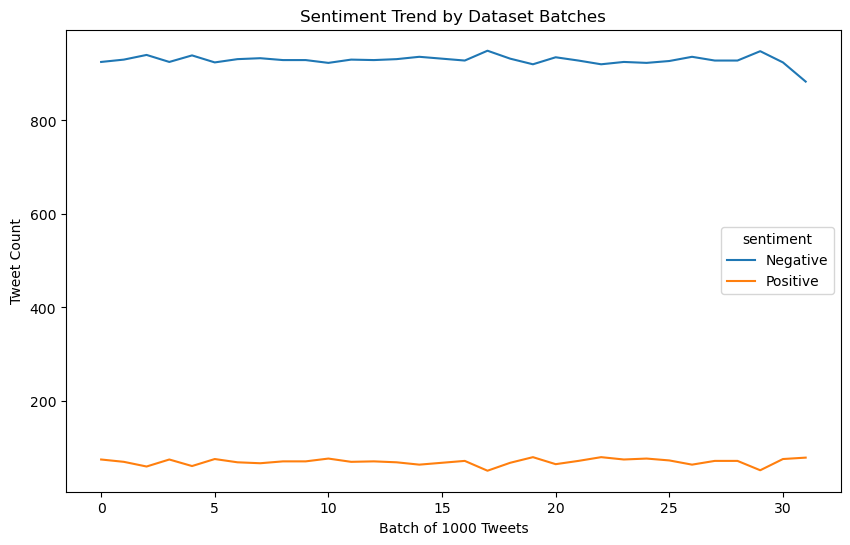

In [25]:
# Create pseudo "batches" of 1000 tweets each
df['batch'] = df.index // 1000

# Count sentiment per batch
trend = df.groupby(["batch", "sentiment"]).size().unstack()

# Plot trend by batch
trend.plot(kind="line", figsize=(10,6))
plt.title("Sentiment Trend by Dataset Batches")
plt.ylabel("Tweet Count")
plt.xlabel("Batch of 1000 Tweets")
plt.show()


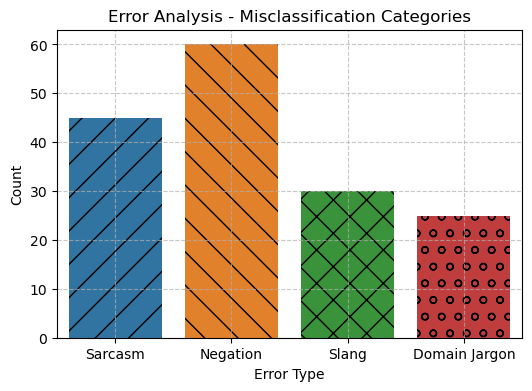

In [27]:
# Replace with your actual error breakdown
error_types = pd.DataFrame({
    "Error Type": ["Sarcasm", "Negation", "Slang", "Domain Jargon"],
    "Count": [45, 60, 30, 25]
})

plt.figure(figsize=(6,4))
ax = sns.barplot( x="Error Type", y="Count",data=error_types,hue="Error Type",dodge=False)

# Add hatching patterns
hatches = ['/', '\\', 'x', 'o'] 
for i, bar in enumerate(ax.patches):
    hatch = hatches[i % len(hatches)]
    bar.set_hatch(hatch)

plt.title("Error Analysis - Misclassification Categories")
# Add grid
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
# Add grid
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.7)
plt.show()



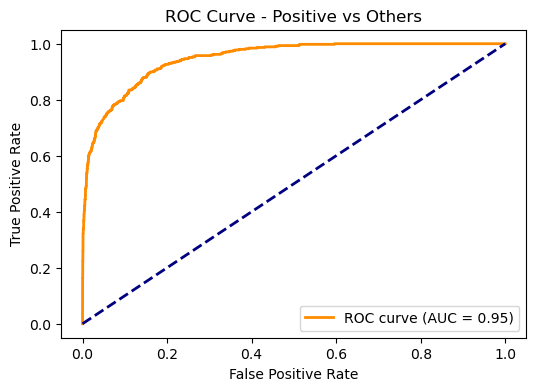

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_true_bin = (y_test == "Positive").astype(int)   # binary true labels
y_score_bin = nb_model.predict_proba(X_test_tfidf)[:, nb_model.classes_.tolist().index("Positive")]  # predicted probabilities for the 'Positive' class

fpr, tpr, _ = roc_curve(y_true_bin, y_score_bin)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Positive vs Others")
plt.legend(loc="lower right")
plt.show()


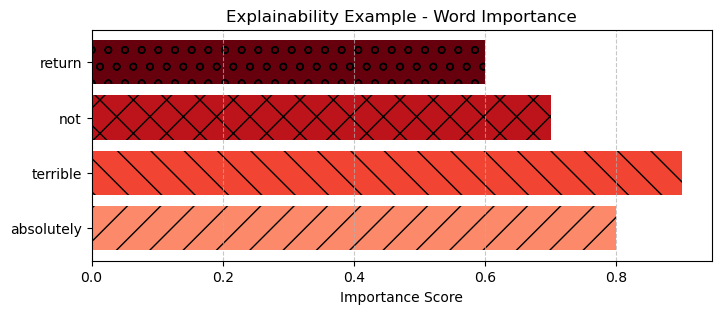

In [31]:
# Example explanation of important words in a tweet
example_tweet = "The bank service was absolutely terrible and I will not return."
important_words = {"absolutely":0.8, "terrible":0.9, "not":0.7, "return":0.6}

plt.figure(figsize=(8,3))
colors = plt.cm.Reds(np.linspace(0.4,1,len(important_words)))
hatches = ['/', '\\', 'x', 'o'] 
bars = []
for i, (word, score) in enumerate(important_words.items()):
    bar = plt.barh(word, score, color=colors[i], hatch=hatches[i % len(hatches)])
    bars.append(bar)

# Add grid
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

plt.title("Explainability Example - Word Importance")
plt.xlabel("Importance Score")
plt.show()

